In [1]:
! git clone https://github.com/Nelson-Gon/cytounet.git

Cloning into 'cytounet'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 932 (delta 21), reused 25 (delta 11), pack-reused 896
Receiving objects: 100% (932/932), 50.44 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (408/408), done.


In [2]:
%cd cytounet

/kaggle/working/cytounet


In [3]:
from cytounet.model import *
from cytounet.data import *
from cytounet.augmentation import *

In [4]:
!  ls examples/BBBC003_v1/

images	truth


In [5]:
data_generator_args =  dict(rotation_range=0.1,
                      rescale = 1./255,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [6]:
! if [ ! -d "aug" ]; then mkdir aug;fi

In [7]:
train_gen = generate_train_data(5, "examples/BBBC003_v1","images", "truth",aug_dict = data_generator_args,
                                 seed = 2, target_size = (512, 512), save_to_dir="aug")

In [8]:
for i, batch in enumerate(train_gen):
    if i>= 5:
        break

Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.


In [9]:
! ls aug | wc -l

60


In [10]:
! if [ ! -d  "aug/images" ]; then mkdir aug/images aug/masks;fi

In [11]:
! mv aug/image_* aug/images && mv aug/mask_* aug/masks && ls aug/masks | wc -l

30


In [12]:
images, masks = load_augmentations("aug/images","aug/masks")

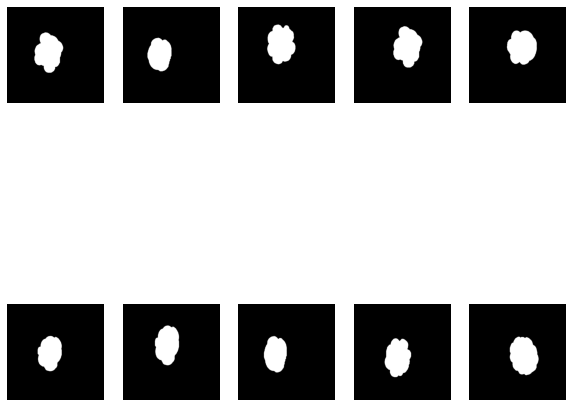

In [13]:
show_images(masks, number=10)

In [14]:
model = unet(input_size = (512, 512, 1), learning_rate = 1e-4, metrics=["accuracy"],
            loss=["binary_crossentropy"])

In [15]:
history = train(model, train_gen, epochs = 5, steps_per_epoch=300, save_as="unet_embryo.hdf5")

Epoch 1/5
300/300 [==============================] - 172s 573ms/step - loss: 0.0958 - accuracy: 0.9728
Epoch 2/5
300/300 [==============================] - 171s 571ms/step - loss: 0.0050 - accuracy: 0.9964
Epoch 3/5
300/300 [==============================] - 172s 573ms/step - loss: 0.0038 - accuracy: 0.9967
Epoch 4/5
300/300 [==============================] - 171s 571ms/step - loss: 0.0033 - accuracy: 0.9968
Epoch 5/5
300/300 [==============================] - 171s 571ms/step - loss: 0.0029 - accuracy: 0.9969


In [16]:
#model.save("unet_embryo.hdf5")

In [17]:

results = predict(model_object=unet(),test_path="aug/images", model_weights="unet_embryo.hdf5",
                  image_length=15, image_suffix="png")


15/15 [==============================] - 0s 7ms/step


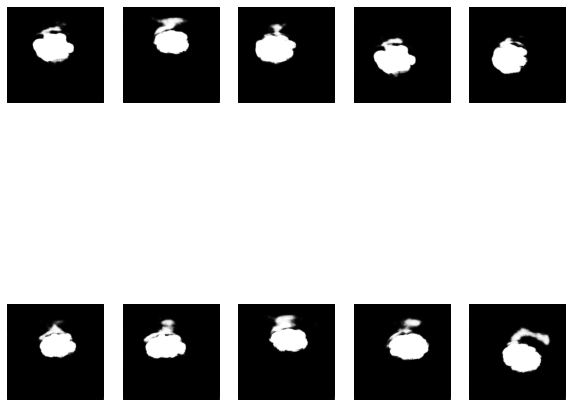

In [18]:
show_images(results, number = 10)